# GP Applied to the Three-Parity Problem

This time we apply GP to a Three-Parity problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP.

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [3]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [4]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10


Set the random seed.

In [38]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [6]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [7]:
NUM_INPUTS = 3
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [8]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

In [39]:
# Define the 3-bit parity problem
def parity3(x1, x2, x3):
    return (x1 + x2 + x3) % 2 == 1

# Create a dataset for the problem
data_points = [(x1, x2, x3, parity3(x1, x2, x3)) for x1 in [0, 1] for x2 in [0, 1] for x3 in [0, 1]]
print(data_points)

[(0, 0, 0, False), (0, 0, 1, True), (0, 1, 0, True), (0, 1, 1, False), (1, 0, 0, True), (1, 0, 1, False), (1, 1, 0, False), (1, 1, 1, True)]


In [10]:
pset1 = gp.PrimitiveSet("PSET1", 3)
pset1.addPrimitive(operator.and_, 2)
pset1.addPrimitive(operator.or_, 2)
pset1.addPrimitive(operator.not_, 1)

pset2 = gp.PrimitiveSet("PSET2", 3)
pset2.addPrimitive(operator.and_, 2)
pset2.addPrimitive(operator.or_, 2)
pset2.addPrimitive(operator.xor, 2)
pset2.addPrimitive(operator.not_, 1)

def if_then_else(condition, out1, out2):
    return out1 if condition else out2

pset3 = gp.PrimitiveSet("PSET3", 3)
pset3.addPrimitive(operator.add, 2)
pset3.addPrimitive(operator.sub, 2)
pset3.addPrimitive(operator.mul, 2)
pset3.addPrimitive(if_then_else, 3)
for i in range(2):
    pset3.addTerminal(i)


In [11]:

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset1, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset1)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset1)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



Set up our population as before

In [12]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [13]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size.

In [14]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std    
0  	2000  	3.9755	0  	6  	2  	2000  	0.572625	19.4975	0  	57 	4  	2000  	11.4694
1  	1789  	3.849 	1  	6  	2  	1789  	0.551542	19.5395	1  	65 	1  	1789  	11.7404
2  	1788  	3.7335	2  	6  	2  	1788  	0.572257	20.7605	2  	66 	1  	1788  	12.1996
3  	1806  	3.686 	3  	6  	2  	1806  	0.609429	21.781 	3  	71 	1  	1806  	12.8346
4  	1819  	3.5835	4  	6  	2  	1819  	0.618892	23.4415	4  	79 	1  	1819  	13.8017
5  	1794  	3.4905	5  	5  	2  	1794  	0.638678	25.4295	5  	83 	1  	1794  	14.5708
6  	1807  	3.445 	6  	6  	1  	1807  	0.678215	27.27  	6  	84 	1  	1807  	14.6716
7  	1775  	3.3755	7  	6  	1  	1775  	0.693902	29.1045	7  	84 	1  	1775  	15.0973
8  	1807  	3.328 	8  	6  	1  	1807  	0.688779	31.014 	8

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  add(if_then_else(if_then_else(0, if_then_else(sub(add(sub(1, if_then_else(1, ARG2, ARG2)), mul(ARG0, 1)), sub(mul(ARG1, 0), mul(ARG0, ARG1))), sub(1, 0), sub(0, ARG1)), add(add(ARG0, 0), sub(ARG1, 1))), if_then_else(if_then_else(add(ARG2, ARG1), ARG0, if_then_else(ARG2, ARG1, ARG0)), ARG2, sub(if_then_else(sub(0, sub(if_then_else(mul(mul(sub(1, ARG1), if_then_else(0, 0, ARG0)), sub(add(ARG1, ARG1), if_then_else(ARG1, ARG0, 1))), 1, 0), ARG0)), ARG1, ARG2), 0)), add(if_then_else(mul(ARG1, ARG0), ARG0, sub(ARG1, ARG2)), if_then_else(add(1, if_then_else(ARG1, ARG0, ARG0)), mul(ARG0, ARG2), mul(0, 1)))), if_then_else(mul(sub(add(ARG2, ARG0), mul(ARG0, ARG2)), sub(add(ARG1, ARG2), mul(mul(if_then_else(1, ARG2, mul(if_then_else(0, 1, ARG0), sub(ARG2, 1))), add(mul(ARG0, 1), if_then_else(0, ARG0, ARG0))), ARG0))), mul(if_then_else(mul(1, 1), add(mul(ARG2, 1), 0), add(ARG0, ARG1)), mul(mul(ARG2, 0), if_then_else(1, ARG1, ARG0))), sub(if_then_else(if_then_else(ARG2, 0, ARG

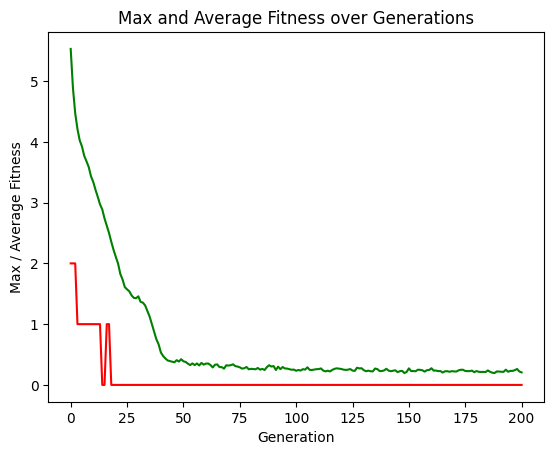

In [29]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best1 = hof.items[0]
print("-- Best Individual = ", best1)
print("-- length={}, height={}".format(len(best1), best1.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

-- Best Individual =  add(if_then_else(if_then_else(0, if_then_else(sub(add(sub(1, if_then_else(1, ARG2, ARG2)), mul(ARG0, 1)), sub(mul(ARG1, 0), mul(ARG0, ARG1))), sub(1, 0), sub(0, ARG1)), add(add(ARG0, 0), sub(ARG1, 1))), if_then_else(if_then_else(add(ARG2, ARG1), ARG0, if_then_else(ARG2, ARG1, ARG0)), ARG2, sub(if_then_else(sub(0, sub(if_then_else(mul(mul(sub(1, ARG1), if_then_else(0, 0, ARG0)), sub(add(ARG1, ARG1), if_then_else(ARG1, ARG0, 1))), 1, 0), ARG0)), ARG1, ARG2), 0)), add(if_then_else(mul(ARG1, ARG0), ARG0, sub(ARG1, ARG2)), if_then_else(add(1, if_then_else(ARG1, ARG0, ARG0)), mul(ARG0, ARG2), mul(0, 1)))), if_then_else(mul(sub(add(ARG2, ARG0), mul(ARG0, ARG2)), sub(add(ARG1, ARG2), mul(mul(if_then_else(1, ARG2, mul(if_then_else(0, 1, ARG0), sub(ARG2, 1))), add(mul(ARG0, 1), if_then_else(0, ARG0, ARG0))), ARG0))), mul(if_then_else(mul(1, 1), add(mul(ARG2, 1), 0), add(ARG0, ARG1)), mul(mul(ARG2, 0), if_then_else(1, ARG1, ARG0))), sub(if_then_else(if_then_else(ARG2, 0, ARG

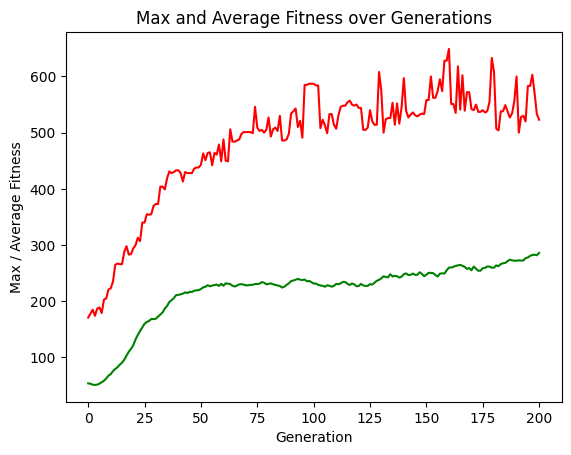

In [31]:
maxFitnessValues, meanFitnessValues = logbook.chapters['size'].select("max", "avg")


# print info for best solution found:
best1 = hof.items[0]
print("-- Best Individual = ", best1)
print("-- length={}, height={}".format(len(best1), best1.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size over Generations')
plt.show()

# Pset 2

In [16]:

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset2, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset2)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset2)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best2 = hof.items[0]


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg 	gen	max	min	nevals	std    	avg    	gen	max	min	nevals	std    
0  	2000  	3.98	0  	8  	0  	2000  	1.01124	22.6005	0  	63 	4  	2000  	13.3957
1  	1807  	3.7305	1  	8  	0  	1807  	0.956488	22.3505	1  	75 	2  	1807  	13.7287
2  	1818  	3.5895	2  	8  	0  	1818  	1.01587 	23.0855	2  	76 	2  	1818  	13.908 
3  	1796  	3.447 	3  	8  	0  	1796  	0.98549 	24.3855	3  	83 	2  	1796  	14.5468
4  	1787  	3.3645	4  	8  	0  	1787  	1.06473 	26.654 	4  	83 	2  	1787  	15.5305
5  	1808  	3.2975	5  	8  	0  	1808  	1.1149  	28.501 	5  	97 	1  	1808  	16.4651
6  	1818  	3.165 	6  	7  	0  	1818  	1.15359 	30.706 	6  	97 	2  	1818  	17.1274
7  	1823  	3.0415	7  	8  	0  	1823  	1.17336 	32.839 	7  	112	2  	1823  	17.7171
8  	1823  	2.908 	8  	8  	0  	1823  	1.19647 	35.092 	8  	118	1

-- Best Individual =  or_(not_(xor(xor(not_(ARG2), xor(ARG1, ARG0)), and_(xor(ARG0, ARG0), not_(ARG1)))), xor(and_(xor(or_(ARG0, ARG1), and_(ARG1, ARG1)), not_(ARG0)), and_(and_(or_(ARG1, ARG2), xor(ARG2, ARG0)), and_(and_(ARG0, ARG0), and_(ARG2, ARG2)))))
-- length=41, height=5
-- Best Fitness =  0.0


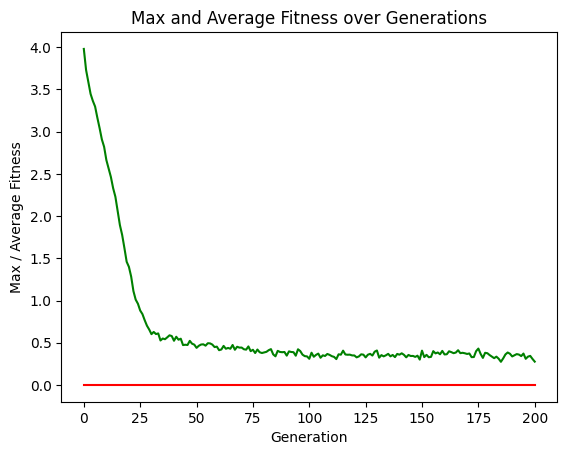

In [17]:
print("-- Best Individual = ", best2)
print("-- length={}, height={}".format(len(best2), best2.height))
print("-- Best Fitness = ", best2.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

-- Best Individual =  add(if_then_else(if_then_else(0, if_then_else(sub(add(sub(1, if_then_else(1, ARG2, ARG2)), mul(ARG0, 1)), sub(mul(ARG1, 0), mul(ARG0, ARG1))), sub(1, 0), sub(0, ARG1)), add(add(ARG0, 0), sub(ARG1, 1))), if_then_else(if_then_else(add(ARG2, ARG1), ARG0, if_then_else(ARG2, ARG1, ARG0)), ARG2, sub(if_then_else(sub(0, sub(if_then_else(mul(mul(sub(1, ARG1), if_then_else(0, 0, ARG0)), sub(add(ARG1, ARG1), if_then_else(ARG1, ARG0, 1))), 1, 0), ARG0)), ARG1, ARG2), 0)), add(if_then_else(mul(ARG1, ARG0), ARG0, sub(ARG1, ARG2)), if_then_else(add(1, if_then_else(ARG1, ARG0, ARG0)), mul(ARG0, ARG2), mul(0, 1)))), if_then_else(mul(sub(add(ARG2, ARG0), mul(ARG0, ARG2)), sub(add(ARG1, ARG2), mul(mul(if_then_else(1, ARG2, mul(if_then_else(0, 1, ARG0), sub(ARG2, 1))), add(mul(ARG0, 1), if_then_else(0, ARG0, ARG0))), ARG0))), mul(if_then_else(mul(1, 1), add(mul(ARG2, 1), 0), add(ARG0, ARG1)), mul(mul(ARG2, 0), if_then_else(1, ARG1, ARG0))), sub(if_then_else(if_then_else(ARG2, 0, ARG

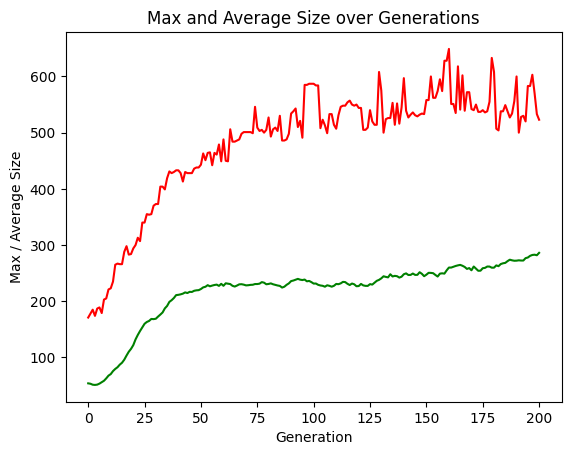

In [36]:
maxFitnessValues, meanFitnessValues = logbook.chapters['size'].select("max", "avg")


# print info for best solution found:
best2 = hof.items[0]
print("-- Best Individual = ", best2)
print("-- length={}, height={}".format(len(best1), best2.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size over Generations')
plt.show()

# Pset3

In [18]:

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset3, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset3)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset3)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best3 = hof.items[0]


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std    	avg  	gen	max	min	nevals	std    
0  	2000  	5.529	0  	8  	2  	2000  	1.32558	53.92	0  	171	15 	2000  	35.9297
1  	1761  	4.883	1  	8  	2  	1761  	1.11638	53.204	1  	178	9  	1761  	37.2594
2  	1807  	4.4705	2  	8  	2  	1807  	0.945055	51.4945	2  	185	1  	1807  	36.1407
3  	1803  	4.211 	3  	8  	1  	1803  	0.852337	51.116 	3  	174	1  	1803  	34.4046
4  	1825  	4.0245	4  	8  	1  	1825  	0.809876	51.635 	4  	187	1  	1825  	34.8565
5  	1828  	3.9235	5  	8  	1  	1828  	0.843592	53.4435	5  	189	1  	1828  	35.8356
6  	1808  	3.7695	6  	8  	1  	1808  	0.813246	55.8725	6  	179	1  	1808  	36.8427
7  	1807  	3.68  	7  	8  	1  	1807  	0.855336	58.509 	7  	203	1  	1807  	37.5382
8  	1786  	3.5855	8  	8  	1  	1786  	0.944293	62.7575	8  	205	3  	17

-- Best Individual =  add(if_then_else(if_then_else(0, if_then_else(sub(add(sub(1, if_then_else(1, ARG2, ARG2)), mul(ARG0, 1)), sub(mul(ARG1, 0), mul(ARG0, ARG1))), sub(1, 0), sub(0, ARG1)), add(add(ARG0, 0), sub(ARG1, 1))), if_then_else(if_then_else(add(ARG2, ARG1), ARG0, if_then_else(ARG2, ARG1, ARG0)), ARG2, sub(if_then_else(sub(0, sub(if_then_else(mul(mul(sub(1, ARG1), if_then_else(0, 0, ARG0)), sub(add(ARG1, ARG1), if_then_else(ARG1, ARG0, 1))), 1, 0), ARG0)), ARG1, ARG2), 0)), add(if_then_else(mul(ARG1, ARG0), ARG0, sub(ARG1, ARG2)), if_then_else(add(1, if_then_else(ARG1, ARG0, ARG0)), mul(ARG0, ARG2), mul(0, 1)))), if_then_else(mul(sub(add(ARG2, ARG0), mul(ARG0, ARG2)), sub(add(ARG1, ARG2), mul(mul(if_then_else(1, ARG2, mul(if_then_else(0, 1, ARG0), sub(ARG2, 1))), add(mul(ARG0, 1), if_then_else(0, ARG0, ARG0))), ARG0))), mul(if_then_else(mul(1, 1), add(mul(ARG2, 1), 0), add(ARG0, ARG1)), mul(mul(ARG2, 0), if_then_else(1, ARG1, ARG0))), sub(if_then_else(if_then_else(ARG2, 0, ARG

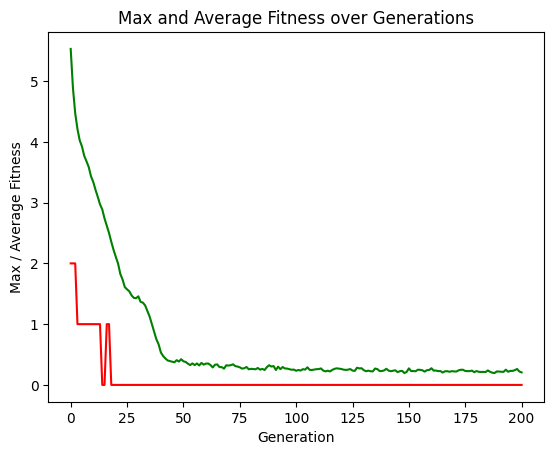

In [19]:
print("-- Best Individual = ", best3)
print("-- length={}, height={}".format(len(best3), best3.height))
print("-- Best Fitness = ", best3.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

-- Best Individual =  add(if_then_else(if_then_else(0, if_then_else(sub(add(sub(1, if_then_else(1, ARG2, ARG2)), mul(ARG0, 1)), sub(mul(ARG1, 0), mul(ARG0, ARG1))), sub(1, 0), sub(0, ARG1)), add(add(ARG0, 0), sub(ARG1, 1))), if_then_else(if_then_else(add(ARG2, ARG1), ARG0, if_then_else(ARG2, ARG1, ARG0)), ARG2, sub(if_then_else(sub(0, sub(if_then_else(mul(mul(sub(1, ARG1), if_then_else(0, 0, ARG0)), sub(add(ARG1, ARG1), if_then_else(ARG1, ARG0, 1))), 1, 0), ARG0)), ARG1, ARG2), 0)), add(if_then_else(mul(ARG1, ARG0), ARG0, sub(ARG1, ARG2)), if_then_else(add(1, if_then_else(ARG1, ARG0, ARG0)), mul(ARG0, ARG2), mul(0, 1)))), if_then_else(mul(sub(add(ARG2, ARG0), mul(ARG0, ARG2)), sub(add(ARG1, ARG2), mul(mul(if_then_else(1, ARG2, mul(if_then_else(0, 1, ARG0), sub(ARG2, 1))), add(mul(ARG0, 1), if_then_else(0, ARG0, ARG0))), ARG0))), mul(if_then_else(mul(1, 1), add(mul(ARG2, 1), 0), add(ARG0, ARG1)), mul(mul(ARG2, 0), if_then_else(1, ARG1, ARG0))), sub(if_then_else(if_then_else(ARG2, 0, ARG

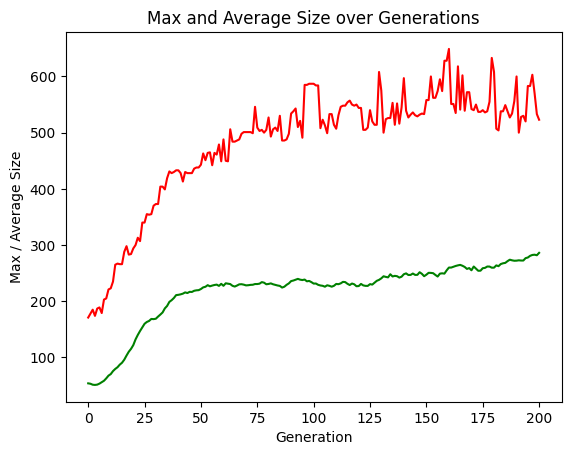

In [37]:
maxFitnessValues, meanFitnessValues = logbook.chapters['size'].select("max", "avg")


# print info for best solution found:
best3 = hof.items[0]
print("-- Best Individual = ", best3)
print("-- length={}, height={}".format(len(best3), best3.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size over Generations')
plt.show()

In [20]:
print(best1)
print(best2)
print(best3)

and_(or_(and_(or_(or_(ARG1, ARG1), and_(or_(or_(or_(not_(ARG0), not_(ARG1)), ARG1), not_(and_(or_(or_(ARG1, ARG0), ARG2), ARG2))), ARG1)), and_(not_(ARG0), not_(ARG2))), or_(and_(and_(ARG0, and_(or_(ARG0, ARG1), and_(ARG0, ARG0))), or_(not_(or_(ARG2, and_(ARG1, ARG0))), and_(and_(or_(and_(and_(ARG2, ARG0), ARG0), ARG2), ARG2), and_(ARG2, and_(not_(and_(not_(and_(and_(and_(or_(or_(or_(ARG2, ARG2), ARG1), not_(ARG2)), or_(or_(ARG1, ARG0), and_(ARG1, ARG1))), or_(or_(not_(ARG0), or_(ARG1, ARG2)), not_(ARG0))), ARG1)), or_(or_(ARG0, ARG1), not_(ARG0)))), ARG1))))), and_(or_(and_(ARG1, ARG0), not_(and_(ARG0, ARG0))), and_(not_(ARG1), and_(or_(and_(not_(ARG1), or_(ARG0, ARG2)), and_(ARG2, ARG0)), not_(ARG1)))))), or_(or_(not_(ARG2), and_(and_(and_(not_(not_(and_(ARG2, or_(and_(and_(or_(ARG2, ARG0), not_(ARG1)), ARG1), and_(ARG1, ARG2))))), or_(ARG0, ARG0)), or_(ARG1, and_(ARG1, ARG2))), and_(ARG1, and_(ARG2, ARG2)))), not_(not_(or_(ARG0, ARG2)))))
or_(not_(xor(xor(not_(ARG2), xor(ARG1, ARG0)